In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import pymc as pm2
import numpy as np

from theano import tensor as T

2980


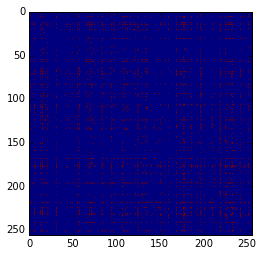

In [11]:
# Load in conv5 activation data and convert to binary convariance by a threshold
x = np.load('/home/ubuntu/sdf/activations/binary_10_conv5.npy')
cov = np.dot(x.transpose(), x)
for i in range(0, cov.shape[0]):
    cov[i, i] = 0
cov /= np.max(cov)
observation_matrix = np.zeros(cov.shape, np.int32)
for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        if cov[i, j] > 0.2:
            observation_matrix[i, j] = 1
print(np.sum(observation_matrix))
plt.imshow(observation_matrix)
plt.show()

num_data = observation_matrix.shape[0]

In [ ]:
# Generate random matrix
import random
num_data = 200
num_classes = 4

# Generate some classes
candidate = [i for i in range(0, num_data)]
classes = np.ndarray(num_data, np.int)
class_count = np.zeros(num_classes, np.int)
class_dist = pm2.Geometric('class_dist', 0.4)
for i in range(0, num_data):
    classes[i] = class_dist.random() - 1
    if classes[i] >= num_classes:
        classes[i] = random.randint(0, num_classes-1)
    class_count[classes[i]] += 1
prob_between_class = np.exp(-np.random.rand(num_classes, num_classes)*2)
print("Class size distribution: " + str(class_count))

In [ ]:
observation_matrix = np.zeros((num_data, num_data), np.int)
for i in range(0, num_data):
    for j in range(i, num_data):   
        if random.random() < prob_between_class[classes[i], classes[j]]:
            observation_matrix[i, j] = 1
        else:
            observation_matrix[i, j] = 0    
        observation_matrix[j, i] = observation_matrix[i, j]
plt.imshow(observation_matrix)
plt.show()

In [ ]:
# Plot correct results for randomly generated data
correct_order = np.argsort(classes)
# Permute the matrix according to the assignments
permuted = np.ndarray((num_data, num_data), np.int)
result = np.ndarray((num_data, num_data), np.int)
for i in range(0, num_data):
    permuted[i, :] = observation_matrix[correct_order[i], :]
for i in range(0, num_data):
    result[:, i] = permuted[:, correct_order[i]]
plt.imshow(result)
class_sum = 0
for i in range(0, num_classes-1):
    class_sum += class_count[i]
    plt.axhline(y=class_sum, c='g')
    plt.axvline(x=class_sum, c='g')
plt.show()

In [14]:
def flatten(mat):
    result = np.ndarray((num_data*num_data,), np.int)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            result[i * mat.shape[1] + j] = mat[i, j]
    return result

In [15]:
beta = 2
num_clusters = 10
 
alpha = pm2.Gamma('alpha', 1., 1.)
mu = pm2.Beta('mu', 2.0, 2.0, size=num_clusters*num_clusters)
# cluster_prior = pm.Dirichlet('cluster_prior', np.ones(num_clusters) / num_clusters)
beta = pm2.Beta('beta', 1., alpha, size=num_clusters)
@pm2.deterministic
def cluster_prior(beta=beta):
    unnormalized = beta * np.concatenate([[1], np.cumprod(1 - beta)[:-1]])
    return unnormalized / np.sum(unnormalized)
# Normalize
assignment = pm2.Categorical('assignment', cluster_prior, size=num_data)

@pm2.deterministic
def prob(assignment1=assignment, assignment2=assignment, mu=mu):
    return [mu[a1 * num_clusters + a2] for a1 in assignment1 for a2 in assignment2]

observation = pm2.Bernoulli('observation', prob, observed=True, value=flatten(observation_matrix))

In [16]:
model = pm2.Model([alpha, mu, beta, cluster_prior, assignment, prob, observation])
mcmc_iter = 4000
mc = pm2.MCMC(model)
mc.sample(mcmc_iter, burn=2000)

 [-----------------100%-----------------] 4000 of 4000 complete in 79.8 sec

In [17]:
cluster_samples = mc.trace("cluster_prior")[:]
assignment_samples = mc.trace('assignment')[:]
import scipy
mode = scipy.stats.mode(assignment_samples, 0)[0][0]
cluster_posterior = list(np.sum(cluster_samples, 0) / float(mcmc_iter))
cluster_posterior /= np.sum(cluster_posterior)
order = np.argsort(mode)
count = np.zeros(num_clusters, np.int)
for item in mode:
    count[int(round(item))] += 1
print(cluster_posterior)
print(count)
print(mode)

[ 0.04216565  0.18059363  0.14012168  0.211303    0.09218651  0.09787491
  0.09634856  0.0643319   0.07339412  0.00168004]
[ 5 53 34 56 18 26 28 11 22  3]
[5 2 6 3 2 3 7 8 3 4 1 6 8 1 8 5 4 1 3 1 1 1 3 3 1 1 3 7 0 8 2 4 2 1 7 3 3
 1 5 3 3 5 2 3 1 3 1 5 3 4 5 3 6 5 7 0 2 6 4 1 3 5 2 3 2 5 3 3 3 1 4 1 7 3
 1 1 8 3 1 1 6 8 8 5 1 3 2 2 3 3 8 9 3 2 5 1 4 3 3 3 8 0 5 3 3 3 5 5 3 2 7
 1 6 2 3 3 5 6 4 1 1 3 6 2 1 3 3 3 4 6 8 2 3 8 2 6 1 1 2 2 3 1 8 2 2 1 4 3
 6 9 2 4 2 2 3 2 6 3 1 4 8 1 1 6 1 2 5 3 1 6 2 6 6 3 6 6 1 3 1 1 1 1 6 5 5
 1 4 4 1 1 1 6 7 8 4 3 7 8 1 7 6 6 6 2 1 6 0 1 3 5 3 1 1 8 2 2 3 7 9 8 6 1
 5 4 2 2 8 8 7 1 3 5 2 3 2 5 1 5 6 4 6 1 3 5 2 8 1 8 8 5 3 0 5 3 4 6]


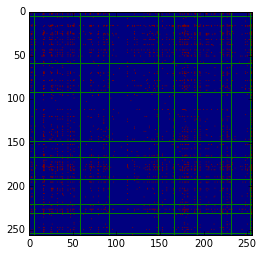

In [18]:
# Permute the matrix according to the assignments
permuted = np.ndarray((num_data, num_data), np.int)
result = np.ndarray((num_data, num_data), np.int)
for i in range(0, num_data):
    permuted[i, :] = observation_matrix[order[i], :]
for i in range(0, num_data):
    result[:, i] = permuted[:, order[i]]
class_sum = 0
for i in range(0, num_clusters-1):
    class_sum += count[i]
    plt.axhline(y=class_sum, c='g')
    plt.axvline(x=class_sum, c='g')
plt.imshow(result)
plt.show()

In [ ]:
# Visualize the derived clusters